In [1]:
# data generation
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
from scipy.stats import gamma, norm, expon
from ipywidgets import interact
from ml import *

# modeling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from datetime import date, datetime
from ipywidgets import interact, interactive, widgets, fixed, Dropdown
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.metrics import r2_score
from scipy.stats import mode
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from datetime import datetime
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
import multiprocessing as mp
import joblib

# Exploratory Calculations

In [2]:
# 2x = x*rate**10
# 2 = rate**10
# 2**(1/10) = rate
print("APR to double principal in 10 years: {:.3f}".format(2**(1/10)))
pd.DataFrame((2**(1/10))**np.arange(18), columns=['{:.3f}'.format(2**(1/10))])

APR to double principal in 10 years: 1.072


,1.072
0,1.000000
1,1.071773
2,1.148698
3,1.231144
4,1.319508
5,1.414214
6,1.515717
7,1.624505
8,1.741101
9,1.866066


In [4]:
# 6% interest
# 60 K
(1.06**np.arange(18)*60).cumsum()

array([  60.        ,  123.6       ,  191.016     ,  262.47696   ,
        338.2255776 ,  418.51911226,  503.63025899,  593.84807453,
        689.478959  ,  790.84769654,  898.29855834, 1012.19647184,
       1132.92826015, 1260.90395575, 1396.5581931 , 1540.35168469,
       1692.77278577, 1854.33915291])

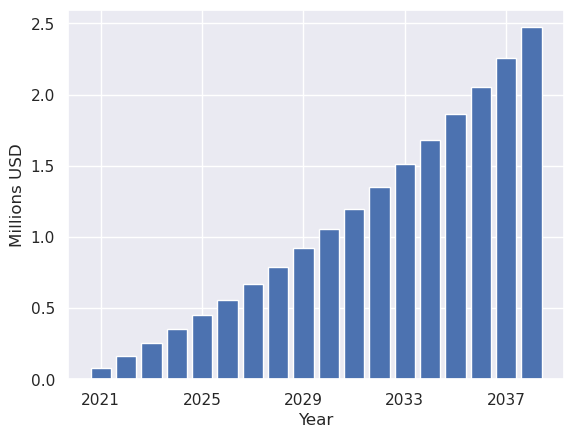

In [5]:
a = np.arange(18)
net = np.cumsum(1.06**a*.08)
plt.bar(np.arange(2021,2021+18), net)
plt.xticks(np.arange(2021, 2021+18, step=4))
plt.xlabel('Year')
plt.ylabel("Millions USD")
plt.show()

In [6]:
principal = widgets.IntSlider(
    value=80,
    min=50,
    max=100,
    step=5,
)

def cap_track(yearly_principal=80, interest=6, years=18):
    int_rate = 1 + interest/100
    a = np.arange(years)
    net = np.cumsum(int_rate**a*yearly_principal/1000)
    
    plt.bar(np.arange(2021,2021+years), net)
    plt.xticks(np.arange(2021, 2021+years, step=4))
    plt.xlabel('Year')
    plt.ylabel("Millions USD")
    plt.title("{} Year Net: {:.2f}M USD\n Annual Interest: {:.1f}K USD".format(years, net[-1], interest/100*net[-1]*1000))
    plt.show()

In [7]:
(18+13)/12

2.5833333333333335

In [8]:
def inctax(income, cap, rate):
    return ((income-cap) * rate)
def calc_tax(income):
    """
    10% $0 to $9,875
    12% $9,876 to $40,125
    $987.50 plus 12% of the amount over $9,875
    22% $40,126 to $85,525
    $4,617.50 plus 22% of the amount over $40,125
    24% $85,526 to $163,300
    $14,605.50 plus 24% of the amount over $85,525
    32% $163,301 to $207,350
    $33,271.50 plus 32% of the amount over $163,300
    35% $207,351 to $518,400
    $47,367.50 plus 35% of the amount over $207,350
    """
    if income > 207350:
        tax = 47367.5 + inctax(income, 163300, .32)
    elif income > 163300:
        tax = 33271.5 + inctax(income, 163300, .32)
    elif income > 85525:
        tax = 14605.5 + inctax(income, 85525, .24)
    elif income > 40125:
        tax = 4617.5 + inctax(income, 40125, .22)
    elif income > 9875:
        tax = 987.5 + inctax(income, 9875, .12)
    else:
        tax = inctax(income, 0, .1)
    return tax

In [9]:
def find_inc(net=130000):
    income = net
    while True:
        check = income - calc_tax(income)
        if check > net:
            break
        income += 1000
    return income

In [10]:
53000/12

4416.666666666667

In [11]:
# my spending 2019: 53000

find_inc(53000+60000)

141000

In [12]:
interact(cap_track, yearly_principal=principal)

interactive(children=(IntSlider(value=80, description='yearly_principal', min=50, step=5), IntSlider(value=6, …

<function __main__.cap_track(yearly_principal=80, interest=6, years=18)>

# Transaction Explore

In [6]:
df = pd.read_csv("transactions.csv")
df = process_data(df, pivot_dates=False)
df = df.loc[df['Date'] >= datetime(2020,1,1)]
df.head()

,Date,Description,Original Description,Amount,Transaction Type,Category,Account Name,Labels,Notes
0,2021-11-22,ONLINE TRANSFER REF #IB0CXBCL75 TO WELLS FARGO...,ONLINE TRANSFER REF #IB0CXBCL75 TO WELLS FARGO...,327.55,debit,Credit Card Payment,Wells Fargo Everyday Checking,NaN,NaN
1,2021-11-22,ONLINE TRANSFER REF #IB0CX4XR53 TO WELLS FARGO...,ONLINE TRANSFER REF #IB0CX4XR53 TO WELLS FARGO...,271.92,debit,Credit Card Payment,Wells Fargo Everyday Checking,NaN,NaN
2,2021-11-22,West Des Moin,ONLINE PAYMENT WEST DES MOIN,327.55,credit,Credit Card Payment,Visa,NaN,NaN
3,2021-11-21,MEDIUM MONTHLY HTTPSMEDIUM.CCA,MEDIUM MONTHLY HTTPSMEDIUM.CCA,5.00,debit,Newspapers & Magazines,Visa,NaN,NaN
4,2021-11-21,Online,ONLINE PAYMENT WEST DES MOIN,271.92,credit,Credit Card Payment,Visa,NaN,NaN


In [7]:
categories = list(df.Category.unique())
income = ['Income', 'Paycheck', 'Transfer', 'Federal Tax', 'Taxes']
taxes = ['Federal Tax', 'Taxes']
internal_acc = ['Credit Card Payment', 'Transfer']
non_expense =  income + taxes + internal_acc
expenses = [i for i in categories if i not in non_expense]

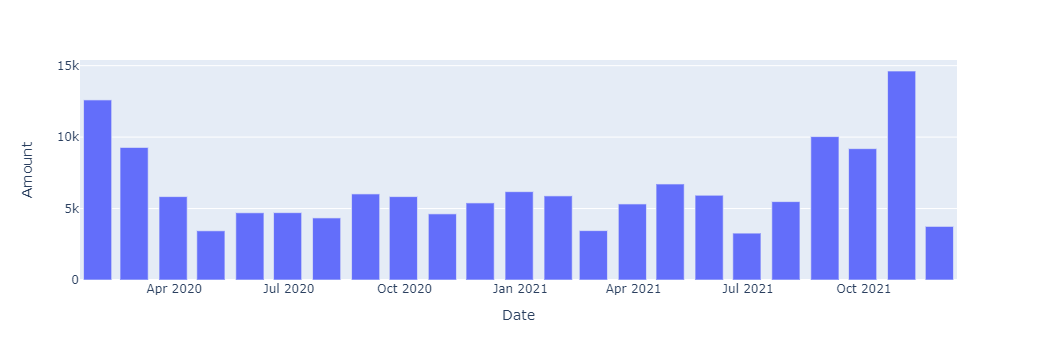

In [8]:
dff = df.loc[df.Category.isin(expenses)].resample(rule='M', on='Date').sum()
px.bar(dff, x=dff.index, y='Amount')

In [144]:
bins = [20, 150]
dff = df.loc[(df.Category.isin(expenses)) &
       (df.Amount < bins[0])].resample(rule='M', on='Date')[['Amount']].sum()
dff.columns = [f'less than {bins[0]}']
dff[f'between {bins[0]} and {bins[1]}'] = df.loc[(df.Category.isin(expenses)) &
                                                 (df.Amount >= bins[0]) &
                                                 (df.Amount < bins[1])].resample(rule='M', on='Date')[['Amount']].sum()
dff[f'greater than {bins[1]}'] = df.loc[(df.Category.isin(expenses)) &
                                                 (df.Amount > bins[1])].resample(rule='M', on='Date')[['Amount']].sum()
dff = dff.reset_index()
dff = dff.melt(id_vars='Date', value_name='Amount', var_name='Category')
dff.head()

,Date,less than 20,between 20 and 150,greater than 150
0,2020-01-31,692.15,2096.81,9812.36
1,2020-02-29,442.88,1846.37,6987.24
2,2020-03-31,333.86,1485.38,4017.49
3,2020-04-30,216.40,1189.66,2037.27
4,2020-05-31,213.66,831.58,3658.95


In [137]:
quantile = .05
mymap1 = (dff.resample(on='Date', rule='M').sum()['Amount'] <= dff.resample(on='Date', rule='M').sum().quantile(quantile)[0]).to_dict()
mymap2 = (dff.resample(on='Date', rule='M').sum()['Amount'] >= dff.resample(on='Date', rule='M').sum().quantile(1-quantile)[0]).to_dict()

mymap = {}
for key, val in mymap1.items():
    if val == True:
        mymap[key] = 'Bottom'
    elif mymap2[key] == True:
        mymap[key] = 'Top'
    else:
        mymap[key] = 'Middle'
dff['Quantile'] = dff['Date'].map(mymap)

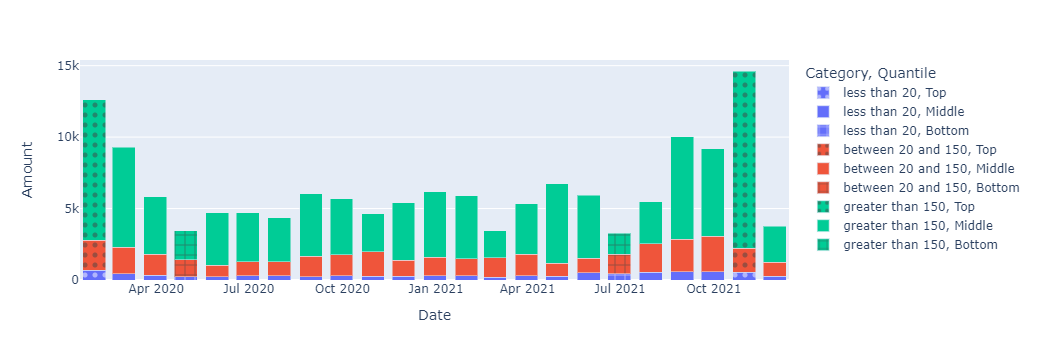

In [128]:
fig = px.bar(dff, x='Date', y='Amount', color='Category', barmode='stack', pattern_shape='Quantile',
      pattern_shape_sequence=[".", "", "+"])
fig.show()

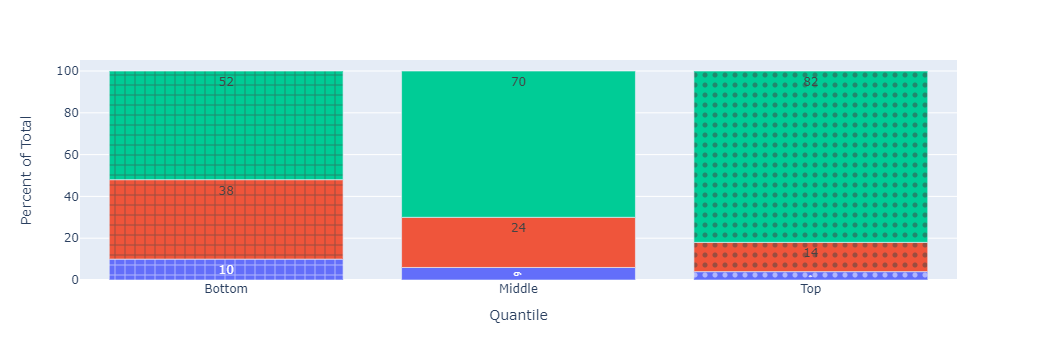

In [134]:
df_compare = pd.DataFrame(dff.groupby(['Quantile', 'Category'])['Amount'].apply(lambda x: x.sum()) /\
    dff.groupby(['Quantile'])['Amount'].apply(lambda x: x.sum())*100).reset_index()
df_compare = df_compare.iloc[[2,0,1,5,3,4,8,6,7]].reset_index(drop=True)
df_compare['Amount'] = round(df_compare['Amount'])
fig = px.bar(df_compare, x='Quantile', y='Amount', color='Category', pattern_shape='Quantile',
      pattern_shape_sequence=["+", "", "."], text='Amount')
fig.update_layout(showlegend=False, yaxis=dict(title='Percent of Total'))

In [11]:
topcut = 20
dff = df.loc[(df['Date'] <= datetime(2022,1,1)) &
             (df['Date'] >= datetime(2021,1,1)) &
             (df['Category'].isin(expenses))]
dfftop = dff.groupby('Category')[['Amount']].sum().sort_values('Amount', ascending=False)[:topcut]
dfftop = dfftop.reset_index()
# px.bar(dff, x=dff.index, y='Amount')
# dff.groupby('Category').apply(lambda x: x['Amount'])
nontop = dff.groupby('Category')[['Amount']].sum().sort_values('Amount', ascending=False)[topcut:].sum().reset_index()
nontop.columns = ['Category', 'Amount']
nontop['Category'] = 'Other'
dfftop = pd.concat([dfftop, nontop]).reset_index(drop=True)
print(dfftop.loc[dfftop['Category'].isin(['Mortgage & Rent', 'Hotel'])]['Amount'].sum())

18448.4


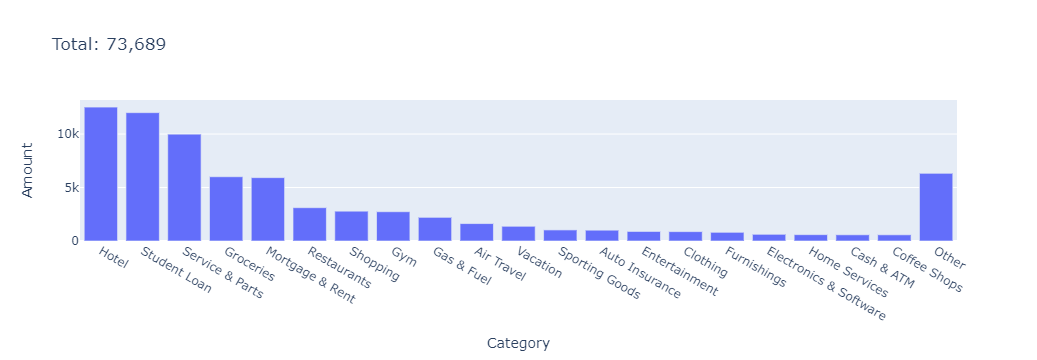

In [12]:
px.bar(dfftop, x='Category', y='Amount', title=f'Total: {dfftop.Amount.sum():,.0f}')

# x-variable

In [156]:
x = 'Category'
bins = [20, 150]
if x != 'Date':
    dff = df.loc[(df.Category.isin(expenses)) &
           (df.Amount < bins[0])].groupby(x)[['Amount']].sum()
    dff.columns = [f'less than {bins[0]}']
    dff[f'between {bins[0]} and {bins[1]}'] = df.loc[(df.Category.isin(expenses)) &
                                                     (df.Amount >= bins[0]) &
                                                     (df.Amount < bins[1])].groupby(x)[['Amount']].sum()
    dff[f'greater than {bins[1]}'] = df.loc[(df.Category.isin(expenses)) &
                                                     (df.Amount > bins[1])].groupby(x)[['Amount']].sum()
else: 
    dff = df.loc[(df.Category.isin(expenses)) &
       (df.Amount < bins[0])].resample(rule='M', on='Date')[['Amount']].sum()
    dff.columns = [f'less than {bins[0]}']
    dff[f'between {bins[0]} and {bins[1]}'] = df.loc[(df.Category.isin(expenses)) &
                                                     (df.Amount >= bins[0]) &
                                                     (df.Amount < bins[1])].resample(rule='M', on='Date')[['Amount']].sum()
    dff[f'greater than {bins[1]}'] = df.loc[(df.Category.isin(expenses)) &
                                                     (df.Amount > bins[1])].resample(rule='M', on='Date')[['Amount']].sum()
dff = dff.reset_index()
dff = dff.melt(id_vars=x, value_name='Amount', var_name='Bin')
dff.head()

,Category,Bin,Amount
0,ATM Fee,less than 20,28.50
1,Advertising,less than 20,24.65
2,Air Travel,less than 20,40.25
3,Alcohol & Bars,less than 20,239.85
4,Auto & Transport,less than 20,11.90


In [158]:
quantile = .05
if x != 'Date':
    mymap1 = (dff.groupby(x).sum()['Amount'] <= dff.groupby(x).sum().quantile(quantile)[0]).to_dict()
    mymap2 = (dff.groupby(x).sum()['Amount'] >= dff.groupby(x).sum().quantile(1-quantile)[0]).to_dict()
else:
    mymap1 = (dff.resample(on='Date', rule='M').sum()['Amount'] <= dff.resample(on='Date', rule='M').sum().quantile(quantile)[0]).to_dict()
    mymap2 = (dff.resample(on='Date', rule='M').sum()['Amount'] >= dff.resample(on='Date', rule='M').sum().quantile(1-quantile)[0]).to_dict()

mymap = {}
for key, val in mymap1.items():
    if val == True:
        mymap[key] = 'Bottom'
    elif mymap2[key] == True:
        mymap[key] = 'Top'
    else:
        mymap[key] = 'Middle'
dff['Quantile'] = dff[x].map(mymap)

In [163]:
dff

,Category,Bin,Amount,Quantile
0,ATM Fee,less than 20,28.50,Middle
1,Advertising,less than 20,24.65,Middle
2,Air Travel,less than 20,40.25,Middle
3,Alcohol & Bars,less than 20,239.85,Middle
4,Auto & Transport,less than 20,11.90,Middle
...,...,...,...,...
142,Sports,greater than 150,NaN,Middle
143,Television,greater than 150,NaN,Middle
144,Travel,greater than 150,318.09,Middle
145,Utilities,greater than 150,452.34,Middle


In [166]:
dfftop = dff.groupby('Category')[['Amount']].sum().sort_values('Amount', ascending=False)[:topcut]
dfftop = dfftop.reset_index()
dfftop

,Category,Amount
0,Hotel,13349.90
1,Groceries,12120.11
2,Service & Parts,10118.41
3,Air Travel,6898.84
4,Restaurants,5156.07
5,Shopping,5131.16
6,Gym,3936.19
7,Gas & Fuel,3643.35
8,Auto Insurance,2312.96
9,Utilities,1720.82


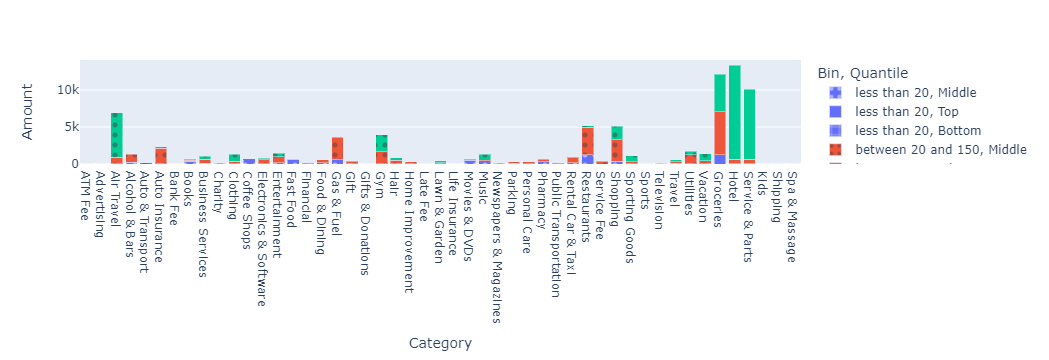

In [162]:
fig = px.bar(dff, x=x, y='Amount', color='Bin', barmode='stack', pattern_shape='Quantile',
      pattern_shape_sequence=[".", "", "+"])
fig.show()